## Import Data

In [69]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

## Show categories

In [19]:
twenty_train.target_names #prints all the categories

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [56]:
import numpy as np
np.shape(twenty_train.data)

(11314,)

In [59]:
print(twenty_train.data[11313]) #prints the last data file

From: gunning@cco.caltech.edu (Kevin J. Gunning)
Subject: stolen CBR900RR
Organization: California Institute of Technology, Pasadena
Lines: 12
Distribution: usa
NNTP-Posting-Host: alumni.caltech.edu
Summary: see above

Stolen from Pasadena between 4:30 and 6:30 pm on 4/15.

Blue and white Honda CBR900RR california plate KG CBR.   Serial number
JH2SC281XPM100187, engine number 2101240.

No turn signals or mirrors, lights taped over for track riders session
at Willow Springs tomorrow.  Guess I'll miss it.  :-(((

Help me find my baby!!!

kjg




In [60]:
print("\n".join(twenty_train.data[-1].split("\n")[:3])) #prints first 3 lines of the last data file

From: gunning@cco.caltech.edu (Kevin J. Gunning)
Subject: stolen CBR900RR
Organization: California Institute of Technology, Pasadena


## Features Extraction

### Count Vectorizer

In [68]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(11314, 130107)

### TF-IDF

In [66]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(11314, 130107)

## Training

### Multinomial Naive Bayes Classifier

In [23]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, twenty_train.target)

### Other alternative using Piplines (CountVectorizer -> TF-IDF-> MNB)

In [24]:
from sklearn.pipeline import Pipeline

text_clf_mnb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB())])

text_clf_mnb = text_clf.fit(twenty_train.data, twenty_train.target)

### Performance of MNB

In [25]:
import numpy as np

predicted = text_clf_mnb.predict(twenty_test.data)
np.mean(predicted == twenty_test.target)

0.7738980350504514

### Try Pipeline with SVM (CountVectorizer -> TF-IDF-> SVM)

In [26]:
from sklearn.linear_model import SGDClassifier
text_clf_svm = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, max_iter=5, random_state=42))])

text_clf_svm = text_clf_svm.fit(twenty_train.data, twenty_train.target)
predicted_svm = text_clf_svm.predict(twenty_test.data)
np.mean(predicted_svm == twenty_test.target)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.8248805098247477

## Grid Search

### Grid Search for MNB

In [27]:
from sklearn.model_selection import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3)}

gs_clf = GridSearchCV(text_clf_mnb, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(twenty_train.data, twenty_train.target)

gs_clf.best_score_
gs_clf.best_params_

{'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

### Grid Search for SVM

In [28]:
from sklearn.model_selection import GridSearchCV
parameters_svm = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False),'clf-svm__alpha': (1e-2, 1e-3)}

gs_clf_svm = GridSearchCV(text_clf_svm, parameters_svm, n_jobs=-1)
gs_clf_svm = gs_clf_svm.fit(twenty_train.data, twenty_train.target)

gs_clf_svm.best_score_
gs_clf_svm.best_params_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


{'clf-svm__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

## NLTK

### Stemming Code

In [33]:
import nltk

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
    
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')

### Classify with MNB

In [34]:
text_clf_mnb_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()), 
                             ('mnb', MultinomialNB(fit_prior=False))])

text_clf_mnb_stemmed = text_clf_mnb_stemmed.fit(twenty_train.data, twenty_train.target)

predicted_mnb_stemmed = text_clf_mnb_stemmed.predict(twenty_test.data)

np.mean(predicted_mnb_stemmed == twenty_test.target)

0.8167817312798725

### Classify with SVM

In [35]:
text_clf_svm_stemmed = Pipeline([('vect', stemmed_count_vect), ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', penalty='l2',alpha=.001, max_iter=5, random_state=42))])

text_clf_svm_stemmed = text_clf_svm_stemmed.fit(twenty_train.data, twenty_train.target)

predicted_svm_stemmed = text_clf_svm_stemmed.predict(twenty_test.data)

np.mean(predicted_svm_stemmed == twenty_test.target)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


0.8201009028146574

### Test for a document

In [104]:
document_idx = 1000
print(twenty_test.data[document_idx:document_idx+1])
print(text_clf_svm_stemmed.predict(twenty_test.data[document_idx:document_idx+1]))
print(twenty_test.target[document_idx])

['From: "Dennis G Parslow" <p00421@psilink.com>\nSubject: Re: John Franco\nIn-Reply-To: <C5wtHC.9I2@world.std.com>\nNntp-Posting-Host: 127.0.0.1\nOrganization: Performance Systems Int\'l\nX-Mailer: PSILink-DOS (3.4)\nLines: 32\n\n>DATE:   Fri, 23 Apr 1993 00:03:11 GMT\n>FROM:   Tackey Chan <tac@world.std.com>\n>\n>wall@cc.swarthmore.edu (Matthew Wall) writes:\n>\n>>So, anybody know what\'s up with John Franco? Are the Mets just starting him\n>>off gingerly because of the small amount of spring training work, or what?\n>\n>\tThe Mets are REALLY starting him off slow. Mike Maddax and\n>Young can do the job of closing. Torborg has said that he Franco is\n>his closer but will give him rest and not rush him since there is no\n>need. He does not want Franco to get hurt on his return. I have this\n>guy so I know what it is like to see him pitch 2 inns in that lat 2\n>weeks. \n>\n>\t\t\t------TAC\n\nWell, they just said that Franco will probably go on the DL tomorrow.\n(They mentioned a career

# Word2Vec

In [20]:
# download glov pretrained vectors from https://nlp.stanford.edu/projects/glove/
# or
#!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

/bin/sh: wget: command not found


In [5]:
import numpy as np

def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
    return words, word_to_vec_map

In [23]:
#glove_file = # use glove data from the previous assignement (Emojyfier folder)
words, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

In [58]:
king = word_to_vec_map["king"]
queen = word_to_vec_map["queen"]
man = word_to_vec_map["man"]
women = word_to_vec_map["women"]
princess = word_to_vec_map["princess"]

## Visualize with T-SNE

In [62]:
arr = np.zeros((5, 50), dtype='f')
arr[0, :] = king
arr[1, :] = queen
arr[2, :] = man
arr[3, :] = women
arr[4, :] = princess

<IPython.core.display.Javascript object>


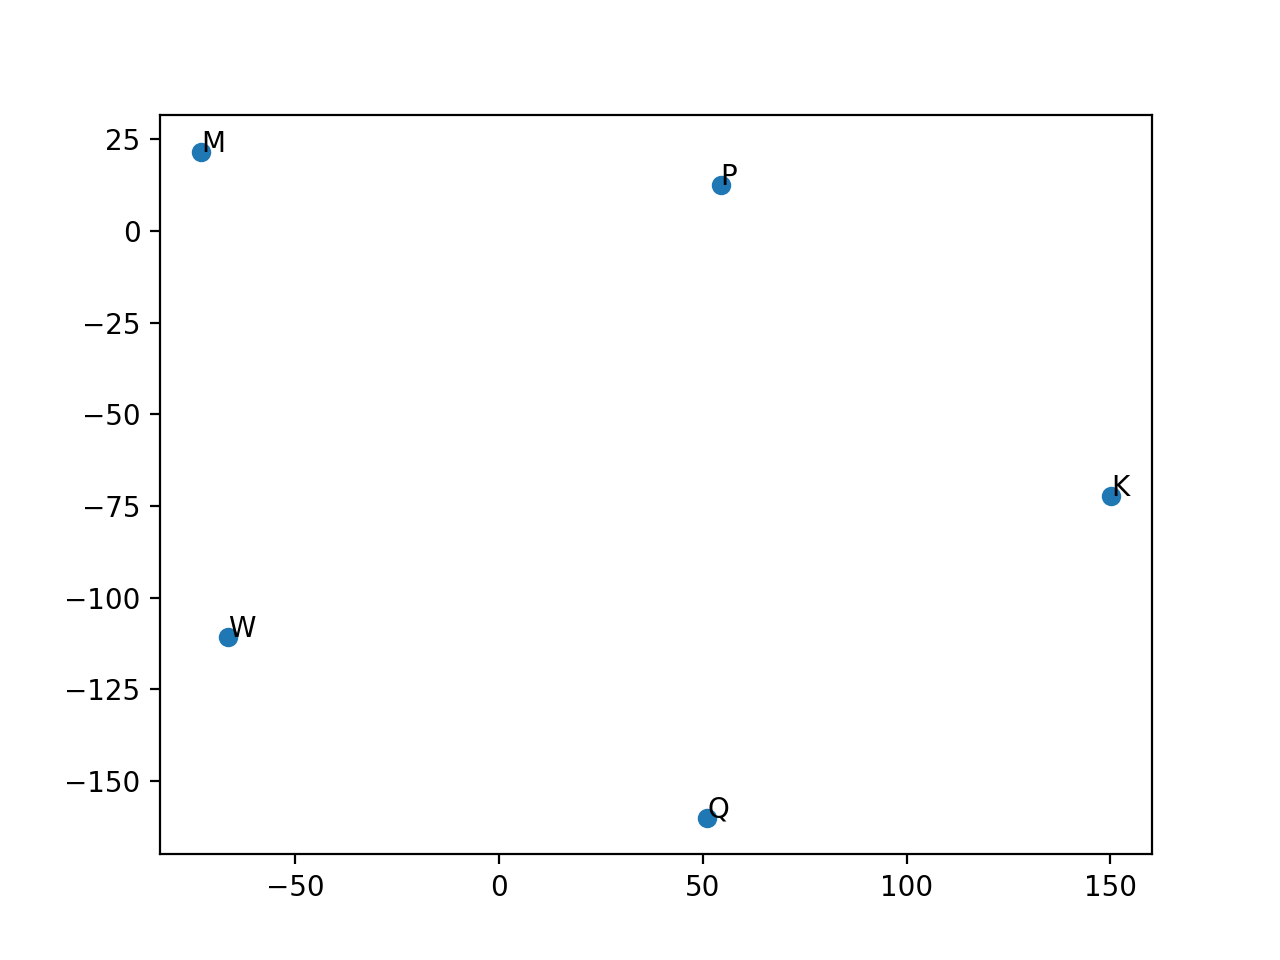

In [61]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(['K', 'Q', 'M', 'W', 'P'], x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()-10, x_coords.max()+10)
plt.ylim(y_coords.min()-10, y_coords.max()+10)
plt.show()